<a href="https://colab.research.google.com/github/Rk-Pudasaini/Ktm_city_temperature_forcast_using_monte_carlo/blob/main/Baysian_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pymc3

In [ ]:
import os
os.environ['THEANO_FLAGS'] = 'blas__check_openmp=False'

In [ ]:
import numpy as np
import pymc3 as pm
import matplotlib.pyplot as plt
import pandas as pd
import calendar
df = pd.read_csv('/content/Kathmandu_Daily_Climate_Data.csv')
df.head()

,YEAR,DOY,T2M,T2MWET,TS,T2M_RANGE,T2M_MAX,T2M_MIN,QV2M,RH2M,PRECTOTCORR,PS,WS2M,WS2M_MAX,WS2M_MIN,WS2M_RANGE,WS10M,WS10M_MAX,WS10M_MIN,WS10M_RANGE
0,1982,1,10.93,4.36,8.14,11.92,18.41,6.48,3.78,41.69,0.0,87.60,1.12,3.20,0.16,3.03,1.67,4.32,0.30,4.02
1,1982,2,10.20,3.57,7.24,11.12,17.26,6.15,3.54,41.00,0.0,87.45,1.17,3.52,0.08,3.45,1.66,4.73,0.07,4.66
2,1982,3,11.08,4.43,8.07,11.27,17.80,6.52,3.78,41.19,0.0,87.49,1.01,3.05,0.04,3.02,1.45,4.05,0.01,4.05
3,1982,4,13.26,6.25,10.29,10.85,20.05,9.19,4.15,39.25,0.0,87.71,1.22,3.06,0.30,2.77,1.76,4.08,0.44,3.64
4,1982,5,14.07,8.05,11.19,10.42,20.92,10.49,5.25,46.62,0.0,87.67,1.68,4.02,0.66,3.36,2.51,5.52,1.07,4.45


In [ ]:
# function to format the date columns in year- month and day type
def format_date(df):
    # Convert Year and DOY columns to datetime
    df['Date'] = pd.to_datetime(df['YEAR'].astype(str) + df['DOY'].astype(str), format='%Y%j')

    # Format the Date column as desired (Year-Month-Day)
    df['Date'] = df['Date'].dt.strftime('%Y-%m-%d')

    # Reorder columns to make "Date" the first column
    date_column = df.pop('Date')
    df.insert(0, 'Date', date_column)

    # Convert 'DATE' column to datetime format
    df['Date'] = pd.to_datetime(df['Date'])

    # Drop the "Year" and "DOY" columns
    df.drop(['YEAR', 'DOY'], axis=1, inplace=True)

    return df

df = format_date(df)
df.head()


,Date,T2M,T2MWET,TS,T2M_RANGE,T2M_MAX,T2M_MIN,QV2M,RH2M,PRECTOTCORR,PS,WS2M,WS2M_MAX,WS2M_MIN,WS2M_RANGE,WS10M,WS10M_MAX,WS10M_MIN,WS10M_RANGE
0,1982-01-01,10.93,4.36,8.14,11.92,18.41,6.48,3.78,41.69,0.0,87.60,1.12,3.20,0.16,3.03,1.67,4.32,0.30,4.02
1,1982-01-02,10.20,3.57,7.24,11.12,17.26,6.15,3.54,41.00,0.0,87.45,1.17,3.52,0.08,3.45,1.66,4.73,0.07,4.66
2,1982-01-03,11.08,4.43,8.07,11.27,17.80,6.52,3.78,41.19,0.0,87.49,1.01,3.05,0.04,3.02,1.45,4.05,0.01,4.05
3,1982-01-04,13.26,6.25,10.29,10.85,20.05,9.19,4.15,39.25,0.0,87.71,1.22,3.06,0.30,2.77,1.76,4.08,0.44,3.64
4,1982-01-05,14.07,8.05,11.19,10.42,20.92,10.49,5.25,46.62,0.0,87.67,1.68,4.02,0.66,3.36,2.51,5.52,1.07,4.45


In [ ]:
def calculate_prior_stats(df):
    monthly_prior_means = []
    monthly_prior_stds = []

    for month in range(1, 13):
        # Filter data for the current month
        month_data = df[df['Date'].dt.month == month]['T2M']

        # Calculate mean and standard deviation for the current month
        mean = month_data.mean()
        std = month_data.std()

        # Append mean and standard deviation to lists
        monthly_prior_means.append(mean)
        monthly_prior_stds.append(std)

    return monthly_prior_means, monthly_prior_stds

# Calculate prior means and standard deviations for each month
monthly_prior_means, monthly_prior_stds = calculate_prior_stats(df)


In [ ]:
def perform_bayesian_inference(monthly_prior_means, monthly_prior_stds, df):
    with pm.Model() as model:
        # Priors for mean and standard deviation
        mu = [pm.Normal(f'mu_{month}', mu=mean, sigma=5) for month, mean in enumerate(monthly_prior_means, start=1)]
        sigma = [pm.HalfNormal(f'sigma_{month}', sigma=std) for month, std in enumerate(monthly_prior_stds, start=1)]

        # Likelihood function
        for month, (m, s) in enumerate(zip(mu, sigma), start=1):
            pm.Normal(f'likelihood_{month}', mu=m, sigma=s, observed=df[df['Date'].dt.month == month]['T2M'])

        # Sample from the posterior distribution
        trace = pm.sample(1000, tune=1000)

        # Sample from the posterior predictive distribution for 2024
        posterior_samples_2024 = [pm.sample_posterior_predictive(trace, samples=1000,
                                                                 var_names=[f'likelihood_{month}'])
                                   for month in range(1, 13)]

    return trace, posterior_samples_2024

def generate_predictions(trace, posterior_samples_2024):
    # Create a list to store daily average temperatures for each month
    daily_avg_by_month = [[] for _ in range(12)]

    # Populate the list with daily average temperatures from the predictive samples
    for month_samples in posterior_samples_2024:
        month_key = next(iter(month_samples))  # Get the first (and only) key
        month_idx = int(month_key.split('_')[1]) - 1  # Extract the month index
        daily_avg_samples = np.mean(month_samples[month_key], axis=1)  # Calculate daily average
        daily_avg_by_month[month_idx].extend(daily_avg_samples)

    return daily_avg_by_month


# Example usage:
trace, posterior_samples_2024 = perform_bayesian_inference(monthly_prior_means, monthly_prior_stds, df)
daily_avg_by_month = generate_predictions(trace, posterior_samples_2024)


/usr/local/lib/python3.10/dist-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)


/usr/local/lib/python3.10/dist-packages/pymc3/sampling.py:1708: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


/usr/local/lib/python3.10/dist-packages/pymc3/sampling.py:1708: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


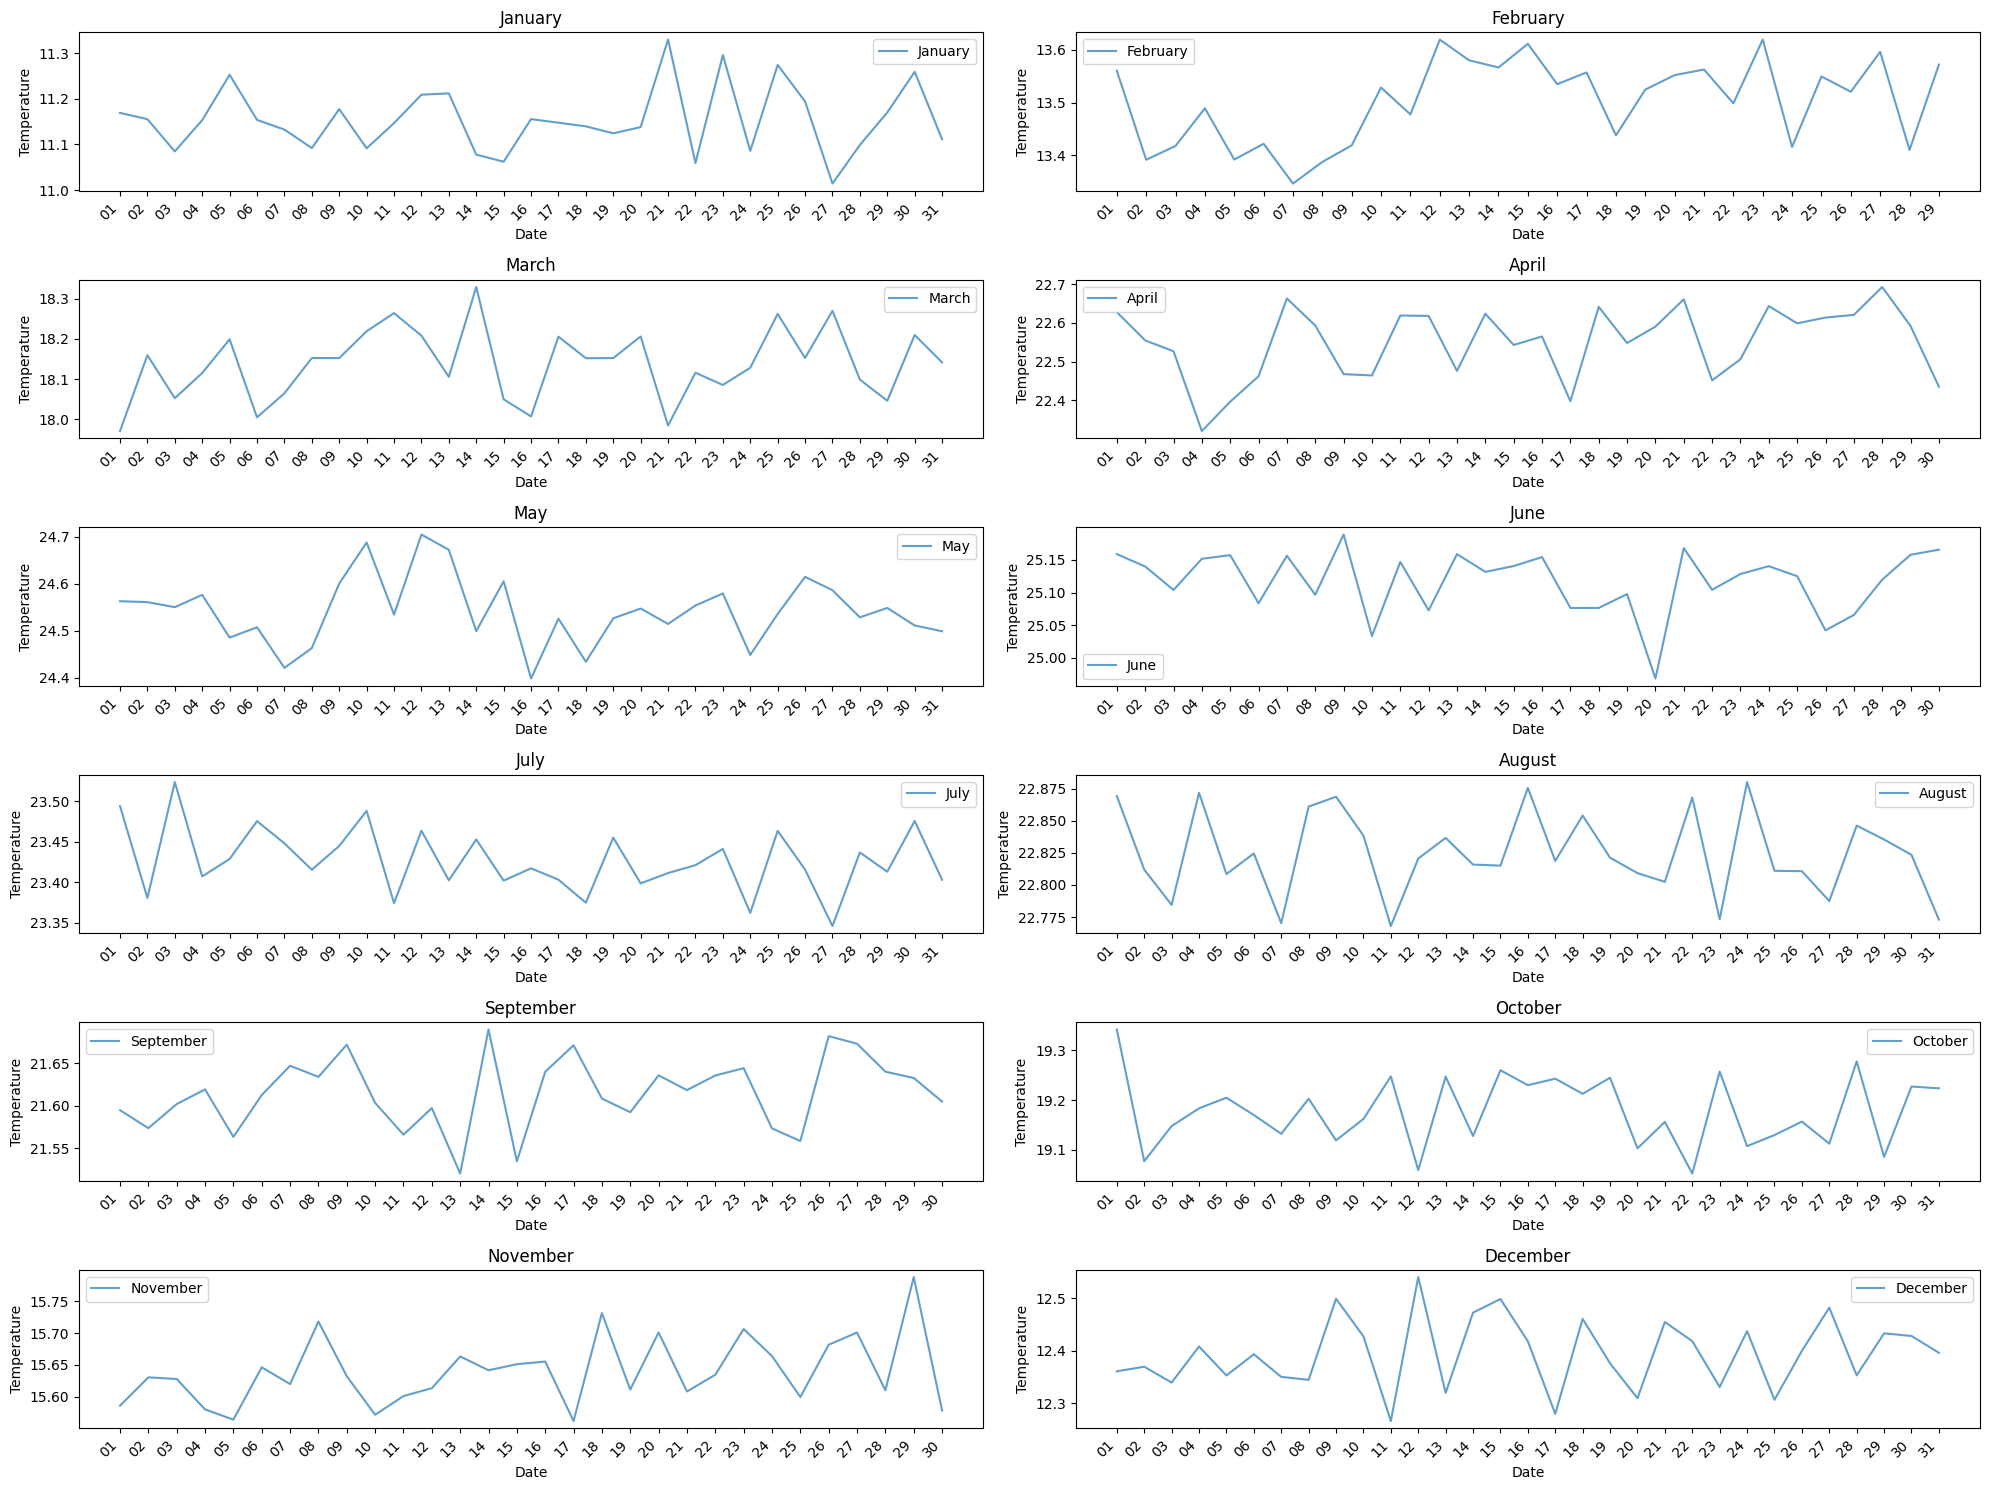

In [ ]:
def plot_monthly_wise(daily_avg_by_month):
    fig, axs = plt.subplots(6, 2, figsize=(20, 15))  # 6 rows, 2 columns for 12 months

    for i, ax in enumerate(axs.flatten(), start=1):
        month_data = daily_avg_by_month[i-1]
        month_year = 2024  # Leap year
        if i == 2:  # February
            if month_year % 4 == 0 and (month_year % 100 != 0 or month_year % 400 == 0):
                num_days_in_month = 29  # Leap year
            else:
                num_days_in_month = 28  # Non-leap year
        else:
            num_days_in_month = calendar.monthrange(2024, i)[1]

        month_start_date = pd.Timestamp(f'{month_year}-{i:02d}-01')  # Pad month with zero if needed
        month_end_date = month_start_date + pd.DateOffset(days=num_days_in_month - 1)  # Calculate end date of the month
        month_dates = pd.date_range(start=month_start_date, end=month_end_date, freq='D')

        # Plot the data for the month
        ax.plot(month_dates, month_data[:num_days_in_month], label=calendar.month_name[i], alpha=0.7)

        # Label each day of the month on the x-axis
        ax.set_xticks(month_dates)
        ax.set_xticklabels([d.strftime('%d') for d in month_dates], rotation=45, ha='right')

        ax.set_xlabel('Date')
        ax.set_ylabel('Temperature')
        ax.set_title(calendar.month_name[i])
        ax.legend()

    plt.tight_layout()
    plt.show()

# Plot monthly-wise with daily monthly data
plot_monthly_wise(daily_avg_by_month)

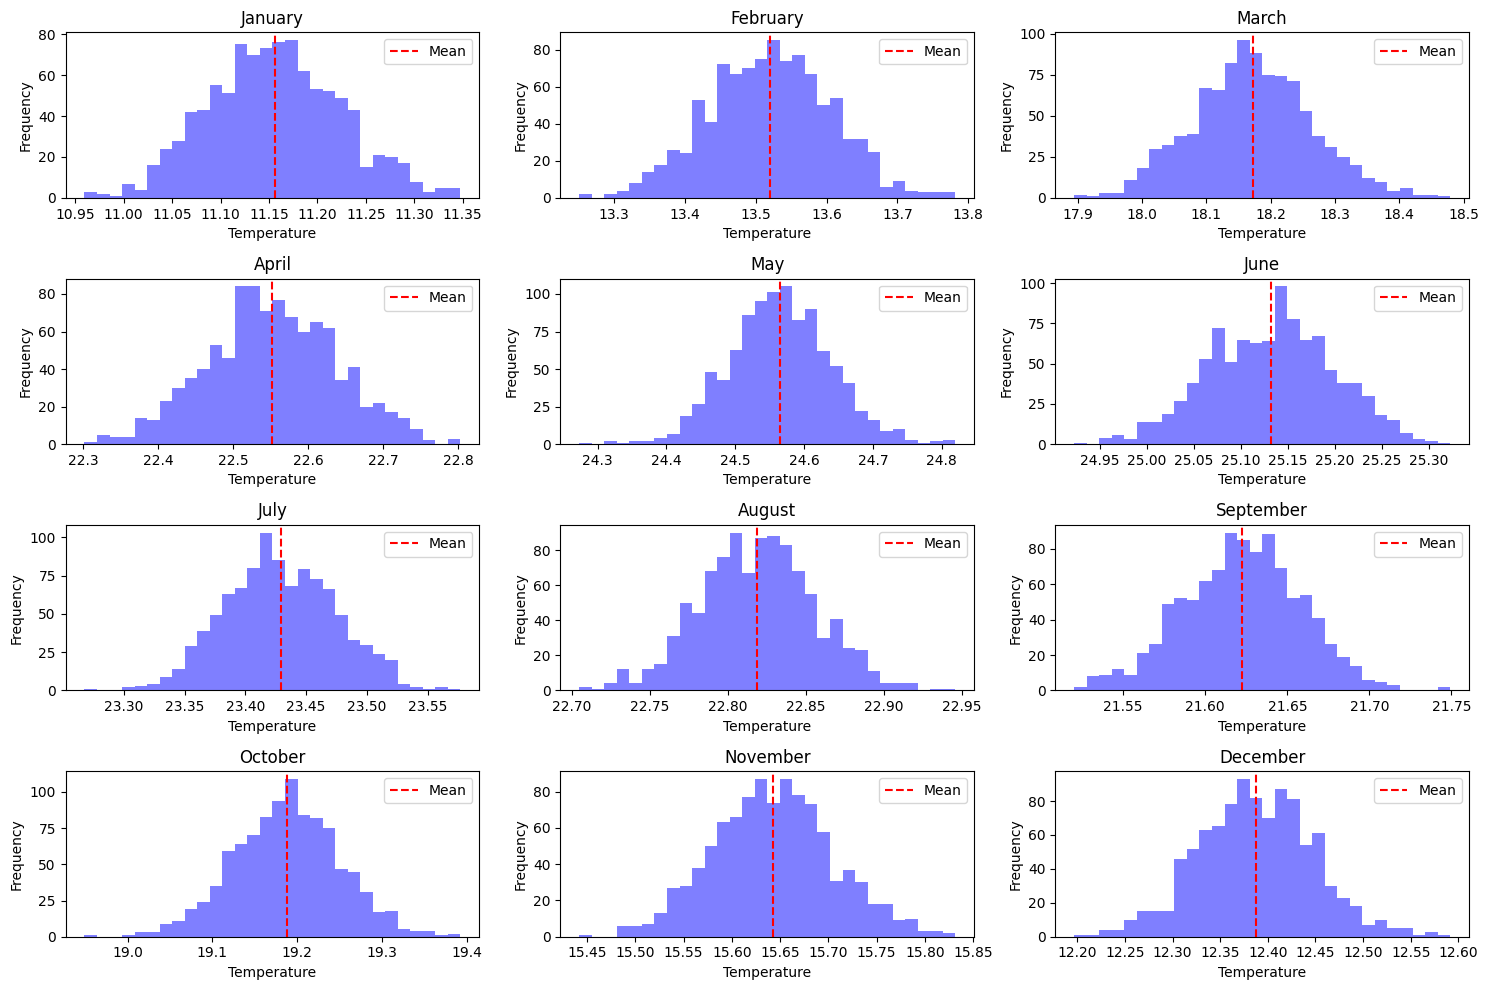

In [ ]:
def plot_monthly_histogram(daily_avg_by_month):
    plt.figure(figsize=(15, 10))

    for i, month_data in enumerate(daily_avg_by_month, start=1):
        plt.subplot(4, 3, i)
        plt.hist(month_data, bins=30, color='blue', alpha=0.5)
        plt.axvline(x=np.mean(month_data), color='red', linestyle='--', label='Mean')
        plt.title(calendar.month_name[i])
        plt.xlabel('Temperature')
        plt.ylabel('Frequency')
        plt.legend()

    plt.tight_layout()
    plt.show()

# Call plot_monthly_histogram function
plot_monthly_histogram(daily_avg_by_month)


In [ ]:
def generate_df_predicted_2024(monthly_averages_30_days):
    # Define the number of days in each month for a non-leap year
    days_in_months_non_leap = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]

    # Create an empty DataFrame to store the predicted temperatures for 2024
    df_predicted_2024 = pd.DataFrame(columns=['Date', 'T2M'])

    # Iterate over each month
    for i in range(1, 13):
        month_data = monthly_averages_30_days[i-1]
        month_year = 2024  # Leap year
        if i == 2:  # February
            if month_year % 4 == 0 and (month_year % 100 != 0 or month_year % 400 == 0):
                num_days_in_month = 29  # Leap year
            else:
                num_days_in_month = 28  # Non-leap year
        else:
            num_days_in_month = days_in_months_non_leap[i-1]

        month_start_date = pd.Timestamp(f'{month_year}-{i:02d}-01')  # Pad month with zero if needed
        month_end_date = month_start_date + pd.DateOffset(days=num_days_in_month - 1)  # Calculate end date of the month
        month_dates = pd.date_range(start=month_start_date, end=month_end_date, freq='D')

        # Create a DataFrame for the current month's data
        month_df = pd.DataFrame({'Date': month_dates, 'T2M': month_data[:num_days_in_month]})

        # Append the current month's data to df_predicted_2024
        df_predicted_2024 = pd.concat([df_predicted_2024, month_df], ignore_index=True)

    return df_predicted_2024

# Generate df_predicted_2024
df_predicted_2024 = generate_df_predicted_2024(daily_avg_by_month)
df_predicted_2024.head()

,Date,T2M
0,2024-01-01,11.168992
1,2024-01-02,11.155236
2,2024-01-03,11.084681
3,2024-01-04,11.153167
4,2024-01-05,11.252364


In [ ]:
#df_predicted_2024.shape

(366, 2)

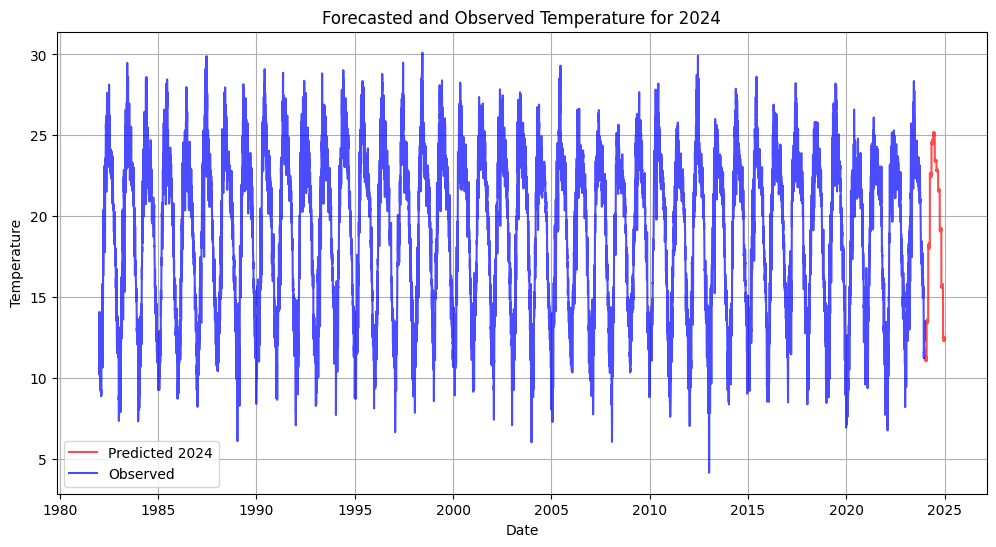

In [ ]:
def combine_predicted_observed(df_predicted_2024, df_observed):
    # Plot the combined forecasted and observed temperatures
    plt.figure(figsize=(12, 6))

    # Plot predicted temperatures for 2024
    plt.plot(df_predicted_2024['Date'], df_predicted_2024['T2M'], label='Predicted 2024', color='red', alpha=0.7)

    # Plot observed temperatures
    plt.plot(df_observed['Date'], df_observed['T2M'], label='Observed', color='blue', alpha=0.7)

    plt.xlabel('Date')
    plt.ylabel('Temperature')
    plt.title('Forecasted and Observed Temperature for 2024')
    plt.legend()
    plt.grid(True)
    plt.show()


# Call combine_predicted_observed function
combine_predicted_observed(df_predicted_2024, df)


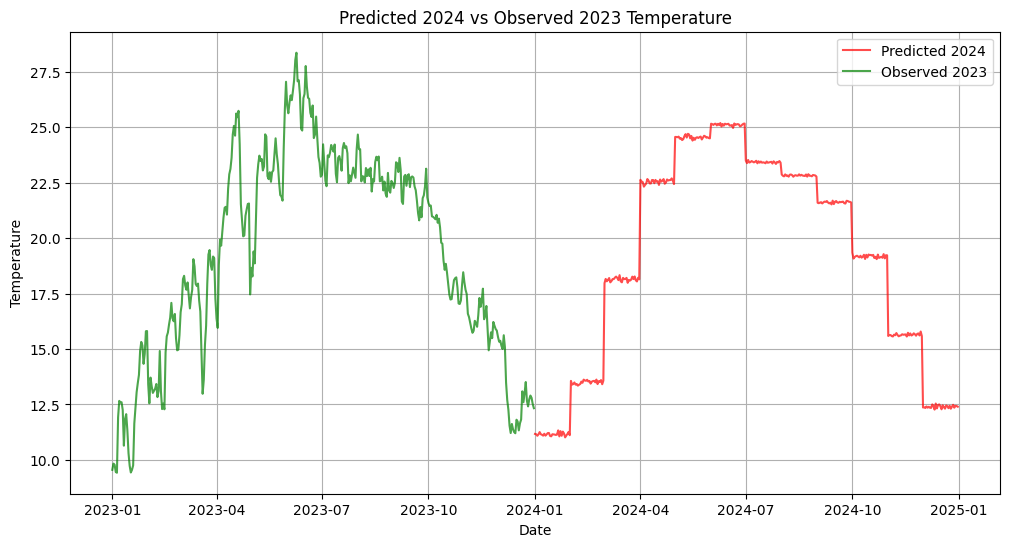

In [ ]:
# Filter data for the previous year (2023)
df_2023 = df[df['Date'].dt.year == 2023]# Get observed temperatures for 2023
#df_observed_2023 = df_2023['T2M']

def compare_2024_predicted_with_2023_observed(df_predicted_2024, df_observed_2023):
    # Plot the combined forecasted temperatures for 2024 and observed temperatures for 2023
    plt.figure(figsize=(12, 6))

    # Plot predicted temperatures for 2024
    plt.plot(df_predicted_2024['Date'], df_predicted_2024['T2M'], label='Predicted 2024', color='red', alpha=0.7)

    # Plot observed temperatures for 2023
    plt.plot(df_2023['Date'], df_2023['T2M'], label='Observed 2023', color='green', alpha=0.7)

    plt.xlabel('Date')
    plt.ylabel('Temperature')
    plt.title('Predicted 2024 vs Observed 2023 Temperature')
    plt.legend()
    plt.grid(True)
    plt.show()


#Compare predicted 2024 temperatures with 2023 observed temperatures
compare_2024_predicted_with_2023_observed(df_predicted_2024, df_2023)